In [7]:
import sys
sys.path.append("..")

import dataInterpreter as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score

In [8]:
data = dt.get_data('Calu3', 'healthy', 'sars-cov2')
columns_healthy = dt.get_columns('Calu3', 'healthy')
columns_sars_cov2 = dt.get_columns('Calu3', 'sars-cov2')

filtered_data = dt.get_p_values('mannwhitneyu', data, columns_healthy, columns_sars_cov2)
filtered_data

,Series7_Calu3_Mock_1,Series7_Calu3_Mock_2,Series7_Calu3_Mock_3,Series7_Calu3_SARS-CoV-2_1,Series7_Calu3_SARS-CoV-2_2,Series7_Calu3_SARS-CoV-2_3,p-value
ISG15,6.251904,7.235619,7.793174,8.923458,8.238008,9.009570,0.040428
MIR200A,1.386294,2.302585,1.098612,0.693147,0.000000,0.693147,0.038261
TNFRSF9,2.397895,0.693147,2.484907,5.273000,4.804021,5.375278,0.040428
CA6,1.098612,1.098612,1.609438,0.693147,0.000000,0.693147,0.036099
SLC2A5,2.302585,2.639057,3.367296,1.945910,0.000000,2.079442,0.040428
...,...,...,...,...,...,...,...
GPC3,3.433987,3.583519,4.477337,3.218876,3.091042,3.135494,0.040428
FAM122C,3.218876,3.555348,4.077537,4.615121,4.248495,4.718499,0.040428
CETN2,6.768493,7.322510,8.040769,6.685861,6.163315,6.532334,0.040428
NSDHL,6.694562,7.395722,8.136518,6.405228,5.793014,6.464588,0.040428


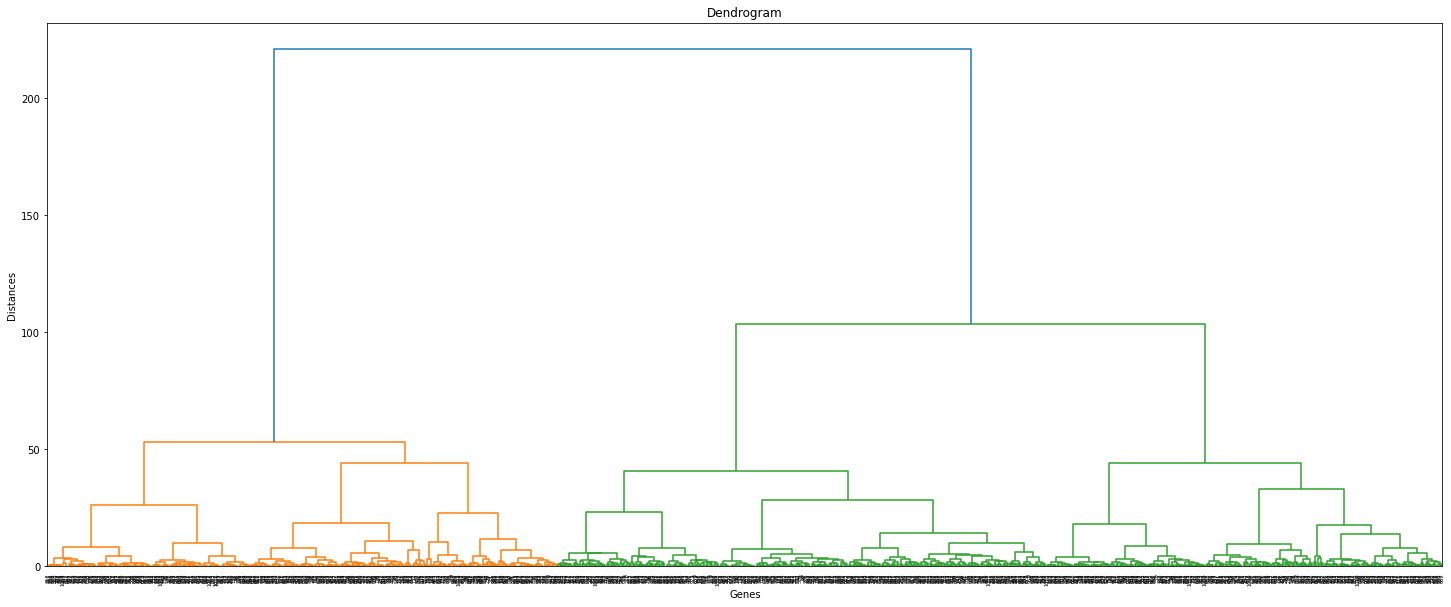

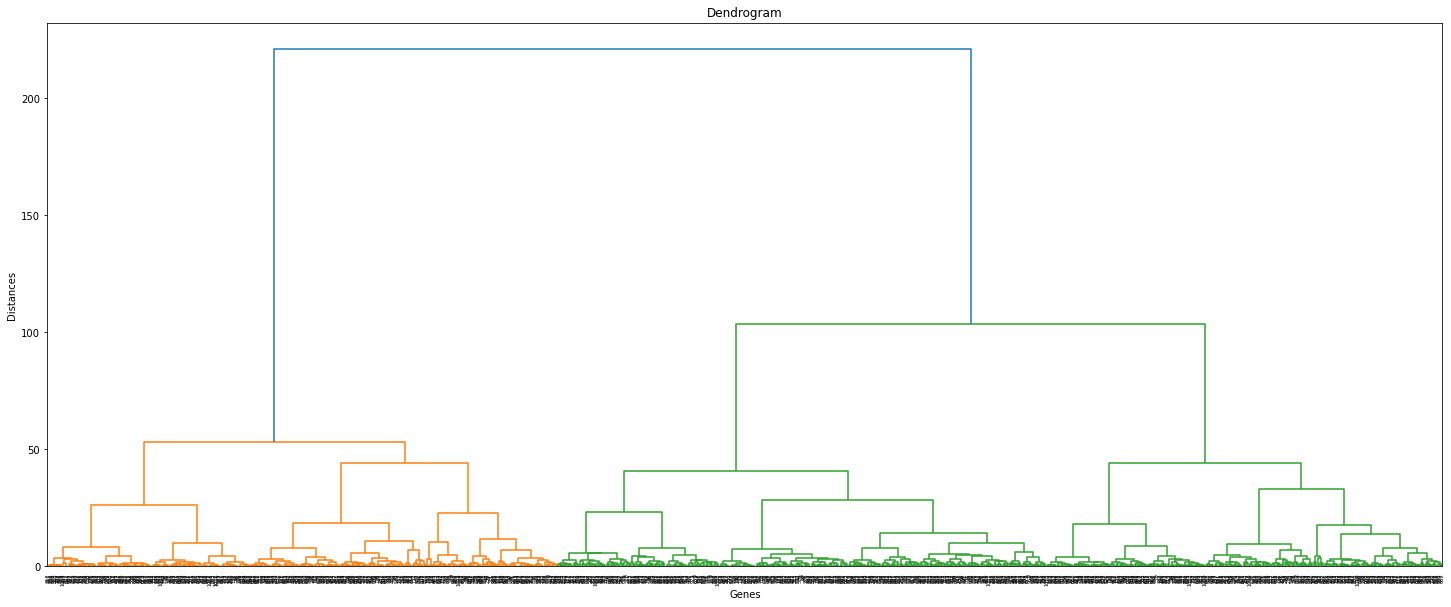

In [5]:
filtered_data.drop(['p-value'], axis = 1, inplace = True)
dt.plot_dendrogram(filtered_data)

In [9]:
labels = {}

models = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
labels['distance'] = models.fit_predict(filtered_data[columns_sars_cov2])

In [10]:
labels['distance']

array([0, 1, 2, ..., 0, 0, 3], dtype=int64)

In [11]:
dissimilarity = 1 - np.abs(filtered_data.T.corr())

m = squareform(dissimilarity)

m[np.abs(m) < 1e-12] = 0

hierarchy = linkage(m, method='ward')
labels['pearson'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [12]:
labels['pearson']

array([1, 0, 2, ..., 0, 0, 0], dtype=int32)

In [13]:
dissimilarity = 1 - np.abs(filtered_data.T.corr(method='spearman'))
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['spearman'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [14]:
labels['spearman']

array([2, 0, 2, ..., 0, 0, 0], dtype=int32)

In [15]:
from itertools import groupby

clusters = {}

for key1, label1 in labels.items():
    clusters[key1] = [list(map(lambda x: x[0], v)) for k,v in groupby(sorted(zip(filtered_data.index, labels['spearman']), key = lambda x: x[1]), lambda s: s[1])]
    
    for key2, label2 in labels.items():
        if key1 != key2:
            print(key1, ' vs ', key2, ': ', adjusted_rand_score(label1, label2))

distance  vs  pearson :  0.14632130136768554
distance  vs  spearman :  0.08366690075047163
pearson  vs  distance :  0.14632130136768554
pearson  vs  spearman :  0.6354210230816951
spearman  vs  distance :  0.08366690075047163
spearman  vs  pearson :  0.6354210230816951


In [ ]:
i = 0
for c in clusters['distance']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['pearson']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['spearman']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [17]:
import enrichmentAnalysis as ea

results_enrichment = {'distance': [], 'pearson': [], 'spearman': []}

for cluster_type in clusters:
    for cluster in clusters[cluster_type]:
        results_enrichment[cluster_type] += [ea.getEnrichment(list(cluster), 'GO_Biological_Process_2021')['GO_Biological_Process_2021']]

results_enrichment

Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlap

{'distance': [[[1,
    'secondary alcohol biosynthetic process (GO:1902653)',
    4.366084865113327e-19,
    47.07747747747748,
    1990.2121330826658,
    ['IDI1',
     'FDPS',
     'MVK',
     'CYP51A1',
     'MSMO1',
     'DHCR24',
     'HMGCR',
     'LSS',
     'ACAT2',
     'TM7SF2',
     'SQLE',
     'EBP',
     'NSDHL',
     'MVD',
     'DHCR7',
     'FDFT1'],
    7.950279410700724e-16,
    0,
    0],
   [2,
    'cholesterol biosynthetic process (GO:0006695)',
    7.902862237277061e-19,
    44.59743954480797,
    1858.9056480812176,
    ['IDI1',
     'FDPS',
     'MVK',
     'CYP51A1',
     'MSMO1',
     'DHCR24',
     'HMGCR',
     'LSS',
     'ACAT2',
     'TM7SF2',
     'SQLE',
     'EBP',
     'NSDHL',
     'MVD',
     'DHCR7',
     'FDFT1'],
    7.950279410700724e-16,
    0,
    0],
   [3,
    'sterol biosynthetic process (GO:0016126)',
    4.10706303547857e-18,
    38.51007371007371,
    1541.705493524233,
    ['IDI1',
     'FDPS',
     'MVK',
     'CYP51A1',
     'MSMO1',

In [18]:
import json

with open('results_Calu3.json', 'w') as file:
     file.write(json.dumps(results_enrichment)) # use `json.loads` to do the reverse

In [19]:
dataset = {'Adjusted p-value': [], 'Combined Score': [], 'Cluster': []}
index = []

for cluster_num in range(len(results_enrichment['distance'])):
    for term in results_enrichment['distance'][cluster_num]:
        index += [term[1]]
        dataset['Adjusted p-value'] += [term[6]]
        dataset['Combined Score'] += [term[4]]
        dataset['Cluster'] += [cluster_num]
enrichment_dataset = pd.DataFrame(dataset, index = index)

In [20]:
pd.set_option("display.max_rows", None)
selection = enrichment_dataset.sort_values('Adjusted p-value').head(25)

selection['Adjusted p-value'] = selection['Adjusted p-value'].map(lambda x: '%.2E' % x)
selection['Combined Score'] = selection['Combined Score'].map(lambda x: '%.2f' % x)

selection.to_csv('Calu3_table.csv')
selection

,Adjusted p-value,Combined Score,Cluster
cytokine-mediated signaling pathway (GO:0019221),9.36E-44,869.33,2
defense response to virus (GO:0051607),9.30E-31,1396.78,2
defense response to symbiont (GO:0140546),9.30E-31,1498.91,2
cellular response to cytokine stimulus (GO:0071345),3.66E-28,483.06,2
negative regulation of viral process (GO:0048525),2.57E-26,1907.45,2
negative regulation of viral genome replication (GO:0045071),8.48E-23,1896.45,2
cellular response to type I interferon (GO:0071357),7.48E-22,1405.26,2
type I interferon signaling pathway (GO:0060337),7.48E-22,1405.26,2
regulation of viral genome replication (GO:0045069),9.17E-19,1016.38,2
negative regulation of cytokine production (GO:0001818),5.62E-17,386.62,2


## Clustering on columns

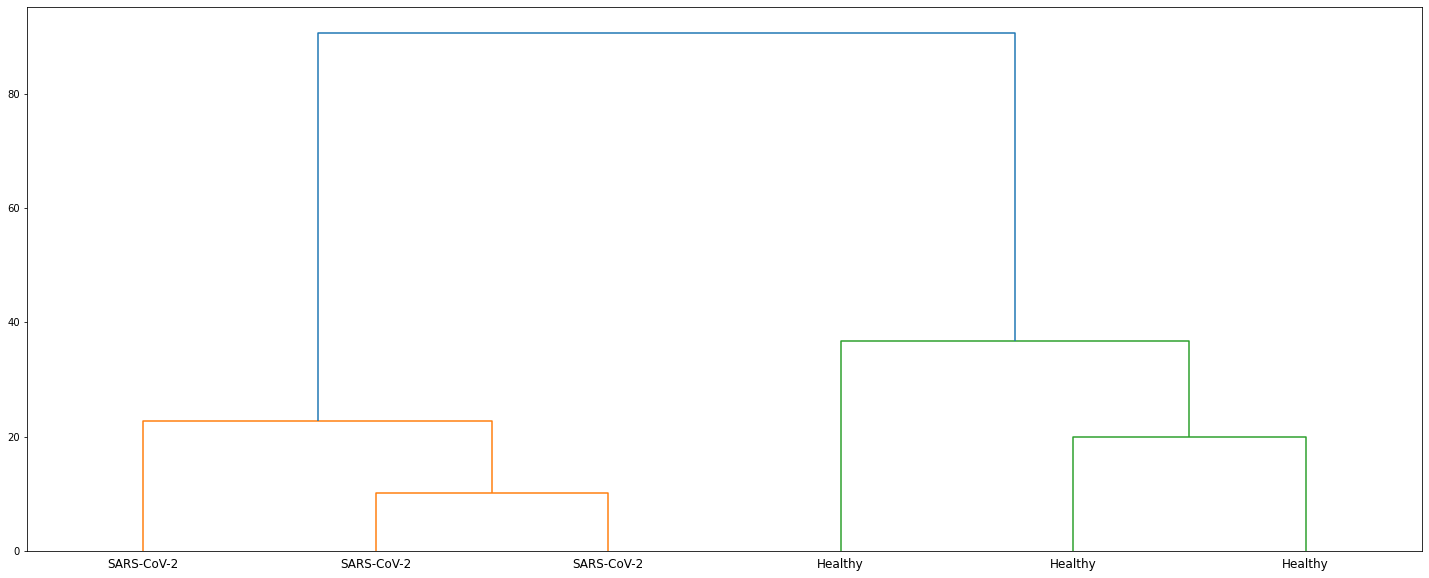

In [6]:
fig = plt.figure(figsize=(25, 10))
dendrogram = sch.dendrogram(sch.linkage(filtered_data.T, method="ward"), labels = list(['Healthy', 'Healthy', 'Healthy', 'SARS-CoV-2', 'SARS-CoV-2', 'SARS-CoV-2']))
plt.show()

In [19]:
labels_columns = {}

models = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
labels_columns['distance'] = models.fit_predict(filtered_data.T)

labels_true = [0 if col in columns_healthy else 1 for col in filtered_data.columns]

print("True: ", labels_true)
print("Predicted: ", labels_columns['distance'])
print(adjusted_rand_score(labels_true, labels_columns['distance']))

True:  [0, 0, 0, 1, 1, 1]
Predicted:  [0 0 0 1 1 1]
1.0
